<center><img src="./images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# ML through Application 
## Module 3, Lab 3: Implementing a DI Remover

This notebook shows you how to quantify disparate impact (DI) and implement a basic DI remover. You will use a logistic regression model to predict whether an individual's income is $\leq$ 50k by using data from the U.S. Census Bureau.

You will learn how to do the following:
- Transform a dataset by using a DI remover.
- Measure DI before and after model training.

__Dataset:__ 
You will use [Folktables](https://github.com/zykls/folktables) to download a dataset for this lab. Folktables provides an API to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files, which the U.S. Census Bureau manages. The data itself is governed by the terms of use that are provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html). 

You will filter the ACS PUMS data sample to include only individuals who are above the age of 16, reported usual working hours of at least 1 hour per week in the past year, and have an income of at least \\$100. 
The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable replacement to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult), but the income threshold can be changed easily to define new prediction tasks. Historically, the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) served as the basis for the development and comparison of many algorithmic fairness interventions but has limited documentation, outdated feature encodings, and only contains a binary target label which can lead to misrepresentations for certain subpopulations. In order to compare your results with scientific findings that utilize the UCI Adult dataset, and to have greater control and flexibility in setting up the problem, you will utilize the ACS PUMS data with the filters and thresholds described above.

__ML problem:__ 
The goal is to predict whether an individual's income is above \\$50,000. 
This is a binary prediction task that can enable organizations and businesses to target their marketing efforts more effectively. Alternatively, governments could leverage these predictions to design better social welfare programs and allocate resources efficiently. Keep these kinds of problems in mind, when working through the notebook.

Reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

----

You will be presented with activities throughout the notebook: <br/>

| <img style="float: center;" src="./images/activity.png" alt="Activity" width="125"/>| 
| --- | 
|<p style="text-align:center;"> No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p>|

## Index

- [Read in the dataset](#Read-in-the-dataset)
- [Data processing](#Data-processing)
- [Train a classifier](#Train-a-classifier)
- [Test the classifier](#Test-the-classifier)

Before loading in the dataset, make sure to install and import all required libraries.

In [1]:
# Use pip to install libraries
!pip install --no-deps -U -q -r requirements.txt

In [2]:
%%capture

# Import the libraries needed for the notebook

# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
from MLUMLA_EN_M3_Lab3_quiz_questions import *
from EqualityOfOddsJupy import *

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *
from aif360.datasets import BinaryLabelDataset, Dataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

---
## Read in the dataset

Import the data from Folktables.

In [3]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grandparents living with grandchildren
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  #  # applies post processing, for example: fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

# Convert NumPy array to DataFrame
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modeling, use only two groups
df = df[df["RAC1P"].isin([6, 8])].copy(deep=True)

---
## Data processing

### EDA

Look at the number of rows, number of columns, and some simple statistics of the dataset.

In [4]:
# Print the first five rows
# NaN means missing data
df.head(10)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,0.0
27,23.0,2.0,21.0,5.0,2545.0,207.0,17.0,20.0,2.0,6.0,35.0,NaN,0.0
33,18.0,1.0,16.0,5.0,9610.0,6.0,17.0,8.0,2.0,6.0,33.0,NaN,0.0
46,40.0,1.0,15.0,3.0,4140.0,303.0,16.0,22.0,1.0,8.0,38.0,2.0,0.0
49,18.0,1.0,18.0,5.0,725.0,6.0,17.0,12.0,2.0,6.0,60.0,NaN,0.0
53,25.0,4.0,21.0,5.0,3870.0,6.0,17.0,40.0,1.0,6.0,50.0,NaN,0.0
64,27.0,1.0,14.0,5.0,7200.0,6.0,16.0,40.0,1.0,8.0,51.0,NaN,0.0
66,29.0,1.0,13.0,5.0,4251.0,312.0,16.0,48.0,1.0,8.0,68.0,NaN,0.0
80,20.0,2.0,17.0,5.0,725.0,6.0,17.0,18.0,2.0,6.0,59.0,NaN,0.0
81,21.0,1.0,19.0,5.0,5820.0,6.0,17.0,38.0,2.0,8.0,64.0,NaN,0.0


In [5]:
# Check how many rows and columns are in the DataFrame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (55502, 13)


In [6]:
# See the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  float64
 1   COW     55502 non-null  float64
 2   SCHL    55502 non-null  float64
 3   MAR     55502 non-null  float64
 4   OCCP    55502 non-null  float64
 5   POBP    55502 non-null  float64
 6   RELP    55502 non-null  float64
 7   WKHP    55502 non-null  float64
 8   SEX     55502 non-null  float64
 9   RAC1P   55502 non-null  float64
 10  PWGTP   55502 non-null  float64
 11  GCL     41987 non-null  float64
 12  >50k    55502 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB


Notice that all columns are numerical (`dtype = float64`). However, check the column headers (and information about the dataset from the links given at the beginning of the notebook), and notice that you are actually dealing with multimodal data. The dataset has a mix of categorical, numerical, and potentially even text information.

You start by creating a list for each feature type. To keep things simple, you should start by only using one feature as sensitive attribute. Cast all other the features according to the desired data type.

In [7]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "GCL",
]

sensitive_attribute = "RAC1P"

numerical_features = ["AGEP", "WKHP", "PWGTP"]

In [8]:
# Cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# Cast the sensitive attribute as `category`
df[sensitive_attribute] = df[sensitive_attribute].astype("object")

# Cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

To make sure that the changes took effect, use `.info()` to check. Compare the results to the `df.info()` output above to make sure the features were cast correctly. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  int64  
 1   COW     55502 non-null  object 
 2   SCHL    55502 non-null  object 
 3   MAR     55502 non-null  object 
 4   OCCP    55502 non-null  object 
 5   POBP    55502 non-null  object 
 6   RELP    55502 non-null  object 
 7   WKHP    55502 non-null  int64  
 8   SEX     55502 non-null  object 
 9   RAC1P   55502 non-null  object 
 10  PWGTP   55502 non-null  int64  
 11  GCL     41987 non-null  object 
 12  >50k    55502 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.9+ MB


Now you can now separate model features from the model target to explore them separately.

In [10]:
model_target = ">50k"
model_features = categorical_features + numerical_features + [sensitive_attribute]

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'GCL', 'AGEP', 'WKHP', 'PWGTP', 'RAC1P']
Model target:  >50k


In [11]:
# Check that the target is not accidentally part of the features
model_target in model_features

False

This looks good. You made sure that the target is not in the feature list. If the output of the previous cell is `True`, you need to remove the target by calling `model_features.remove(model_target)`.

Next, you will look for missing values.

#### Check for missing values

The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of missing values.

You can also see the count of missing values with `.info()` because the function provides a count of non-null values.

In [12]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
>50k         0
dtype: int64

If you find a column where the majority of the values are missing, consider to exclude this column from the feature list. Alternatively, you can find a way to fill the missing values and impute them.

In [13]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
>50k         0
dtype: int64

In [14]:
df.head(10)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,>50k
0,30,6.0,14.0,1.0,9610.0,6.0,16.0,40,1.0,8.0,32,2.0,0.0
27,23,2.0,21.0,5.0,2545.0,207.0,17.0,20,2.0,6.0,35,NaN,0.0
33,18,1.0,16.0,5.0,9610.0,6.0,17.0,8,2.0,6.0,33,NaN,0.0
46,40,1.0,15.0,3.0,4140.0,303.0,16.0,22,1.0,8.0,38,2.0,0.0
49,18,1.0,18.0,5.0,725.0,6.0,17.0,12,2.0,6.0,60,NaN,0.0
53,25,4.0,21.0,5.0,3870.0,6.0,17.0,40,1.0,6.0,50,NaN,0.0
64,27,1.0,14.0,5.0,7200.0,6.0,16.0,40,1.0,8.0,51,NaN,0.0
66,29,1.0,13.0,5.0,4251.0,312.0,16.0,48,1.0,8.0,68,NaN,0.0
80,20,2.0,17.0,5.0,725.0,6.0,17.0,18,2.0,6.0,59,NaN,0.0
81,21,1.0,19.0,5.0,5820.0,6.0,17.0,38,2.0,8.0,64,NaN,0.0


In [15]:
model_target = ">50k"
model_features = categorical_features + numerical_features + [sensitive_attribute]

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'GCL', 'AGEP', 'WKHP', 'PWGTP', 'RAC1P']
Model target:  >50k


Before starting to create plots, look at how many unique instances you have per column. This helps you avoid plotting charts with hundreds of unique values. To do this, filter for columns with fewer than 10 unique instances.

In [16]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
GCL      2.0
RAC1P    2.0
dtype: float64


#### Check the target distribution

Check the target distribution.

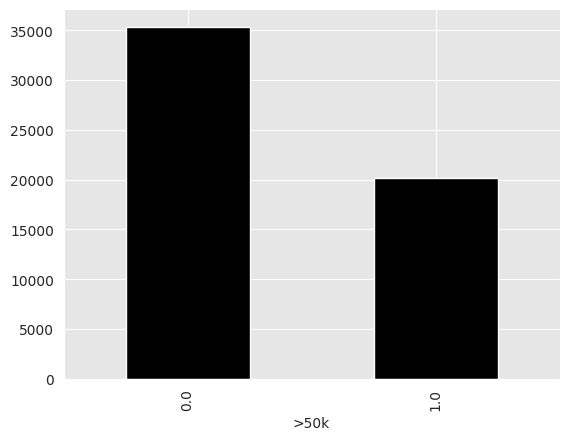

In [17]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

Notice that the dataset is imbalanced. This means that the dataset has more examples for one type of result (here: 0; meaning individuals that earn $\leq$ 50k). This is relevant for model choice and potential upsampling or downsampling to balance out the classes.

#### Create feature distributions

Now, plot bar charts for the shortlist features (feature columns with fewer than 10 unique instance classes) of the dataset.

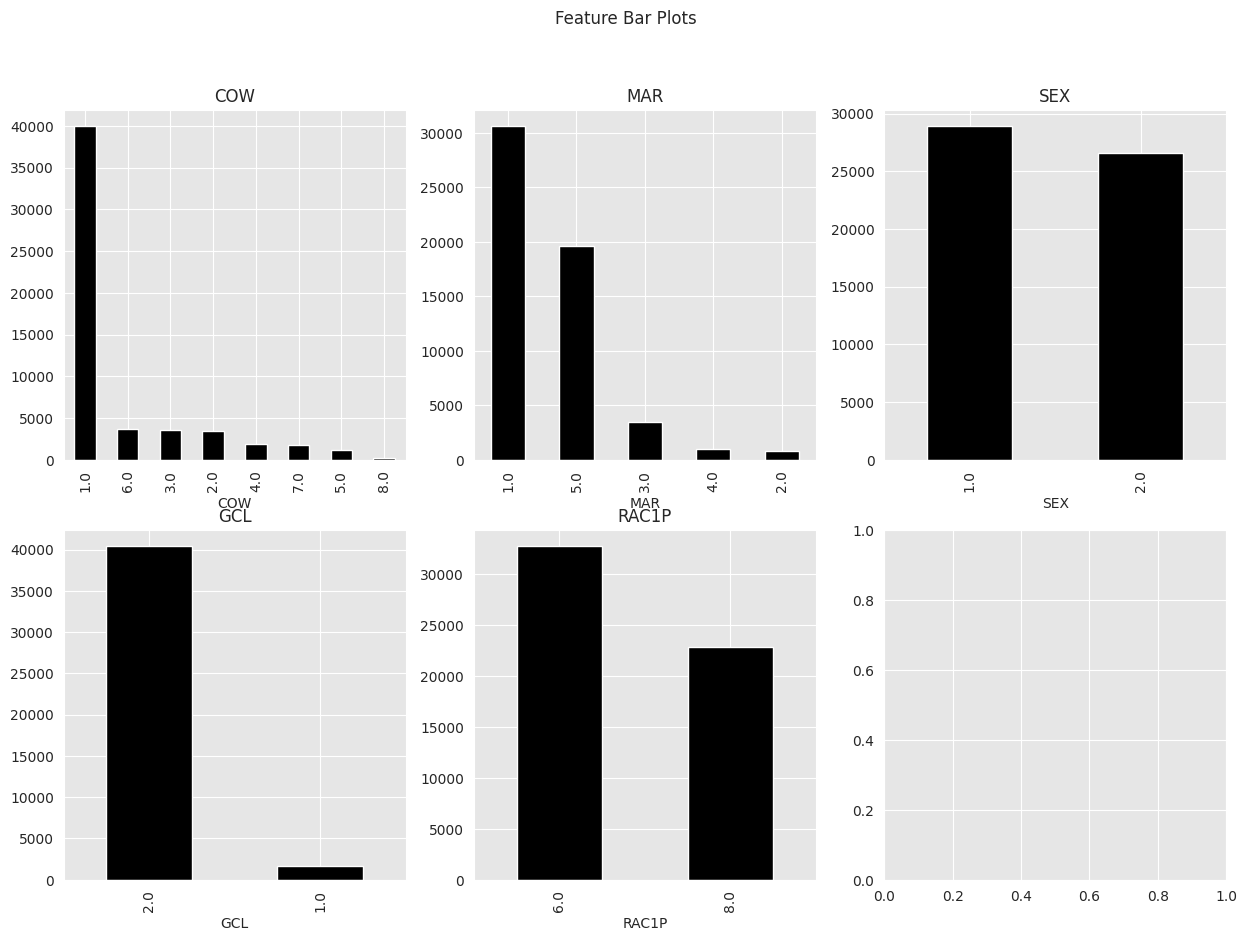

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Feature Bar Plots")

fts = range(len(shortlist_fts.index.tolist()))
for i, ax in zip(fts, axs.ravel()):
    df[shortlist_fts.index.tolist()[i]].value_counts().plot.bar(color="black", ax=ax)
    ax.set_title(shortlist_fts.index.tolist()[i])
plt.show()

### Select features to build the model 

The GCL feature is equally present in both outcome instances and also contains a lot of missing values. Therefore, you can drop it from the list of features that you want to use for model build just like you dropped OCCP and POBP since those features had more than 10 unique categories.

In [19]:
to_remove = ["GCL", "OCCP", "POBP"]

# Drop to_remove features from the respective list(s) - if applicable
for ft in to_remove:
    if ft in model_features:
        model_features.remove(ft)
    if ft in categorical_features:
        categorical_features.remove(ft)
    if ft in numerical_features:
        numerical_features.remove(ft)

# Clean up the DataFrame and only keep the features and columns that are needed
df = df[model_features + [model_target]].copy(deep=True)

### Feature transformation

In the paper [Certifying and Removing Disparate Impact](https://arxiv.org/pdf/1412.3756.pdf), a definition for disparate impact (DI) was introduced as the ratio of probability of positive outcomes for the disfavored group $(A=0)$ to the probability of positive outcomes for the favored group $(A=1)$:  

$\Large DI = \frac{Pr(Y=y|A=0)}{Pr(Y=y|A=1)}$

To be free of DI, the resulting value from the equation needs to be $>$0.8 (and as close to 1 as possible). However, achieving this can be difficult.

Run the following code cell, and look at the interactive visualization to compare two groups: triangles and circles. This example has a positive outcome (accepted) and a negative outcome (rejected). You might notice that the triangle group is favored because more than 50 percent of the triangles have historical records (truth) for "accepted. At this point, you can calculate the DI by counting how many positive outcomes a group has divided by the group total. This will confirm that the triangle group is favored.

Next, move the slider (which represents a classifier threshold) on the first plot to see if a threshold value exists where the probabilities to receive a positive (or negative) outcome are equal across groups.

Notice that it's impossible to find one position where the probabilities for both groups are the same. This makes sense because the distributions of accepted/rejected differ by group. Therefore, a single threshold will not work equally well for both groups.

At this point, you have different options, including the following:
- Transform the data so that the distributions of the groups look more similar (DI remover).
- Train a classifier and use different probability thresholds.

In this notebook, you will see the transformation of data (DI remover). In another lab, you will see a postprocessing technique that uses different probability thresholds for different groups.

In [20]:
EqualityOfOddsJupy()

### Create training, test, and validation datasets 

To get training, test, and validation sets, use scikit-learn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [21]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
)

train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the datasets
print(
    "Train - Test - Validation dataset shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation dataset shapes:  (42458, 10) (5551, 10) (7493, 10)


### Process the data with a pipeline and ColumnTransformer 

Next, you will build a data processing pipeline. You need a preprocessing split per data type. Then, you will combine everything into a composite pipeline. To achieve this, you will use scikit-learn's `Pipeline` and `ColumnTransformer`.

__Step 1: Set up preprocessing per data type__

For the numerical features pipeline (`numerical_processor` in the following code cell), impute missing values with the mean by using scikit-learn's `SimpleImputer`. Then, use `MinMaxScaler` (you don't need to scale features when using decision trees, but it's a good idea to see how to use data transforms). If different processing is desired for different numerical features, you should build different pipelines, as shown for the two categorical text features.

In the categorical features pipeline, (`categorical_processor` in the following code cell), impute with a placeholder value and encode with scikit-learn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check unique values for categoricals to get an estimate of how many dummy features will be created by one-hot encoding. Note the `handle_unknown` parameter, which tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation or test set that was not present in the initial training set.

__Step 2: Combine preprocessing methods into a transformer__ 

The selective preparations of the dataset features are then put together into a collective `ColumnTransformer` to finally be used in a pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset through cross-validation or making predictions on a test dataset in the future.

In [22]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from step 1
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ],
    remainder="drop",
)

Apply the transformation before performing DI removal.

In [23]:
# Learn the transformation and extract the feature names
data_processor.fit(train_data)

# To extract feature names, first fit the data processor because
# this will generate the one-hot encoding
ft_names = numerical_features + list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names_out(categorical_features)
)

train_prep = data_processor.transform(train_data).todense()

prep = np.concatenate(
    (
        train_prep,
        train_data[[model_target]].values,
        train_data[[sensitive_attribute]].values,
    ),
    axis=1,
)

# Add column names and convert to a DataFrame
prep_df = pd.DataFrame(prep, columns=ft_names + [model_target] + [sensitive_attribute])

For the DI transformation, you need to create an Artificial Intelligence Fairness (AIF360) dataset using the AIF360 library. You can do this by using `BinaryLabelDataset`. Then, you can use `DisparateImpactRemover`.

In [24]:
# Create a dataset construct for AIF360
binaryLabelDataset = BinaryLabelDataset(
    df=prep_df,
    label_names=[">50k"],
    protected_attribute_names=["RAC1P"],
    favorable_label=1.0,
    unfavorable_label=0.0,
)

# Use DisparateImpactRemover at a medium repair level
di_remover = DisparateImpactRemover(repair_level=0.9)

# Perform the transformation
binaryLabelDataset_transform = di_remover.fit_transform(binaryLabelDataset)

# Save as a DataFrame
df_transform = binaryLabelDataset_transform.convert_to_dataframe()[0]

In [25]:
# Print the first rows of the transformed dataset
df_transform.head()

,AGEP,WKHP,PWGTP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,...,RELP_12.0,RELP_13.0,RELP_14.0,RELP_15.0,RELP_16.0,RELP_17.0,SEX_1.0,SEX_2.0,RAC1P,>50k
0,0.259740,0.295918,0.045711,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0
1,0.259740,0.540816,0.035692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0
2,0.051948,0.010204,0.045085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,0.0
3,0.220779,0.397959,0.035066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0
4,0.038961,0.020408,0.062617,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,0.0


For easier readability, show the original DataFrame so that you can compare directly.

In [26]:
# Print the first rows of the orignal dataset
prep_df.head()

,AGEP,WKHP,PWGTP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,...,RELP_12.0,RELP_13.0,RELP_14.0,RELP_15.0,RELP_16.0,RELP_17.0,SEX_1.0,SEX_2.0,>50k,RAC1P
0,0.272727,0.295918,0.045711,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0
1,0.272727,0.55102,0.035692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0
2,0.051948,0.010204,0.045085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0
3,0.233766,0.397959,0.035066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0
4,0.038961,0.020408,0.062617,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0


Now, look at the transformed dataset. You can see that certain values were adjusted.

As a final check, you can also calculate the DI value. To do this, you need to specify which group is favored.

In [27]:
# Declare what the attribute value of the (un)privileged group is
priv_group = [{"RAC1P": 6}]
unpriv_group = [{"RAC1P": 8}]

# Find out which index the sensitive attribute has to delete later
sensitive_attribute_index = binaryLabelDataset_transform.feature_names.index(
    sensitive_attribute
)

Next, calculate the DI value with the AIF360 inbuilt method `BinaryLabelDatasetMetric()`. You need to pass the DataFrame into the metric, and then you can calculate DI by using `.disparate_impact()`.

In [28]:
# Calculate the DI value
print(
    BinaryLabelDatasetMetric(
        binaryLabelDataset,
        unprivileged_groups=unpriv_group,
        privileged_groups=priv_group,
    ).disparate_impact()
)

0.39943748594510425


To see how to calculate the DI value for the transformed dataset, run the following code:

In [29]:
BinaryLabelDatasetMetric(
        binaryLabelDataset_transform,
        unprivileged_groups=unpriv_group,
        privileged_groups=priv_group,
    ).disparate_impact()

0.39943748594510425

The value shouldn't change because the remover does not touch the labels. The goal of the DI remover is to shift the distribution of the nonsensitive features while preserving the labels.

---
## Train a classifier

Use the transformed dataset and a logistic regression estimator for training.

Train the classifier with `.fit()` on the repaired training dataset.

In [30]:
# Extract features (and delete the sensitive attribute) and label
X_train = np.delete(
    binaryLabelDataset_transform.features, sensitive_attribute_index, axis=1
)
y_train = binaryLabelDataset_transform.labels.ravel()

# Initialize model
lr = LogisticRegression(solver="liblinear", penalty="l2", C=0.001)


# Train model
lr.fit(X_train, y_train)

# Predict
y_train_pred = lr.predict(X_train)

---
## Test the classifier

Now, evaluate the performance of the trained classifier on the transformed test dataset by using `.predict()`.

Make sure to repair (DI transform) the test dataset as well.

In [31]:
test_prep = np.concatenate(
    (
        data_processor.transform(test_data).todense(),
        test_data[[model_target]].values,
        test_data[[sensitive_attribute]].values,
    ),
    axis=1,
)

# Add column names and convert to a DataFrame
test_prep_df = pd.DataFrame(
    test_prep, columns=ft_names + [model_target] + [sensitive_attribute]
)

# Create a dataset construct for AIF360
binaryLabelDataset_test = BinaryLabelDataset(
    df=test_prep_df,
    label_names=[">50k"],
    protected_attribute_names=["RAC1P"],
    favorable_label=1.0,
    unfavorable_label=0.0,
)

# Transform the test dataset
test_repd = di_remover.fit_transform(binaryLabelDataset_test)

# Get test data to validate the classifier
X_test = np.delete(test_repd.features, sensitive_attribute_index, axis=1)
y_test = test_repd.labels.ravel()

# Use the fitted model to make predictions on the test dataset
test_predictions = lr.predict(X_test)

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">How can you calculate the accuracy for the test dataset?</p>
    <p style=" text-align: center; margin: auto;">To answer the question, run the following cell.</p>
    <br>
</div>

In [32]:
# Run this cell for a knowledge check question
question_1

From the previous notebooks, you might remember that the accuracy was similar.

Now, check whether the outcomes are fairer too. For this, create a DataFrame that contains the predictions as well as the sensitive attribute and the true labels.

In [33]:
# Create a DataFrame that contains predictions and the sensitive attribute
di_df = pd.concat(
    [
        test_data.reset_index(drop=True)[["RAC1P", ">50k"]],
        pd.Series(test_predictions, name="y_test_pred_di"),
    ],
    axis=1,
)

To check the DI of the predictions, you need to create a `BinaryLabelDataset` again.

In [34]:
# Create a dataset construct for AIF360
pred_binaryLabelDataset = BinaryLabelDataset(
    df=di_df,
    label_names=["y_test_pred_di"],
    protected_attribute_names=["RAC1P"],
    favorable_label=1.0,
    unfavorable_label=0.0,
)

In [35]:
print(
    BinaryLabelDatasetMetric(
        pred_binaryLabelDataset,
        unprivileged_groups=unpriv_group,
        privileged_groups=priv_group,
    ).disparate_impact()
)

0.2190424795107897


This is much lower than the values that you had originally (before the transformation). Remember that you want a value greater than 0.8 (and as close to 1 as possible).

How good is this model in terms of outcomes for the individuals in the dataset?

You can plot the distribution of targets and inspect whether the model works equally well for different subgroups.

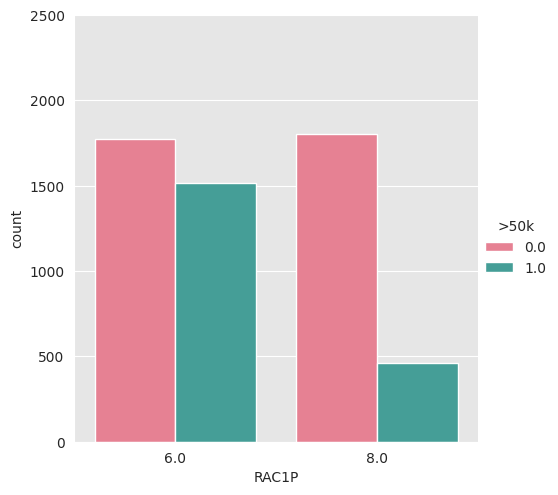

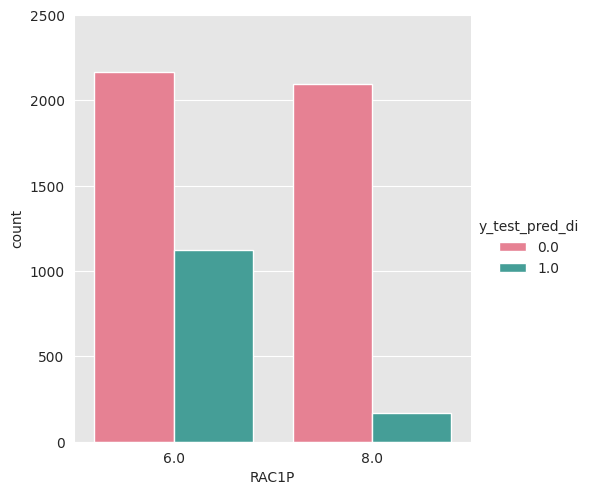

In [36]:
%matplotlib inline
sns.catplot(x="RAC1P", kind="count", hue=model_target, data=di_df, palette="husl")
plt.ylim(0, 2500)
sns.catplot(x="RAC1P", kind="count", hue="y_test_pred_di", data=di_df, palette="husl")
plt.ylim(0, 2500)
plt.show()

---
## Conclusion
Similar to what you had in the previous model, you have underpredictions in the >50k class. Furthermore, for this particular dataset, the DI transformation did not have the desired effect because the disfavored group is still at a disadvantage (relative to ground truth). Compared to the previous notebook, the results are certainly more fair because group 6 has fewer positive outcomes, and group 8 has more positive outcomes (compared to a model that was trained without any intervention at all). However, this is still not ideal. Also, is this actually fair for group 6 now, which has fewer positive outcomes than in the ground truth?

## Next lab
In the next lab, you will learn about bias mitigation during model training and postprocessing by using reweighing and equalized odds.